## FANTASY LEAGUE ULTIMATE TEAM PREDICTOR

## Business Problem

The Saudi Splurge FC team began the first half of the 2023/24 season well by ranking in the top 0.8% of FPL managers worldwide. However, performance in the second half of the season has been poor resulting in a substantial drop down the rankings to the top 8.5% of managers after game week 25. 

The Saudi Splurge FC team want to start using data available in the FPL to help predict the best team to select for each game week that will maximize the points scoring potential, and overall improve their rankings.

## Deliverables
1. Evaluate how match difficulty impacts points scoring potential for each positions (GK,DEF,MID,FWD).
2. Determine the best starting formation to use for each game week.
3. Provide a predicted team that factors in the rules and constraints of the FPL such as bugdet, maximum numbers of players per team etc.

<IPython.core.display.Javascript object>


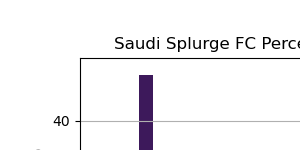

Text(13.5, 5.777462594875324, 'Top 0.8%')

In [1]:
import pandas as pd
import requests as r
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandasql as sql
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from pulp import LpProblem, LpVariable, lpSum, LpMaximize

#Team ID for Saudi Splurge FC
team_id = 2240973

#API request for season performance
history_url = f"https://fantasy.premierleague.com/api/entry/{team_id}/history/"

json_data = r.get(history_url).json()

history_df = pd.DataFrame(json_data['current'])

#Save histroy to excel
history_df.to_excel('current_season_performance.xlsx')

################################################################################################################################
#Plot Season Match Week Overall Ranking Percentiles 
%matplotlib notebook

#Get total number of league players
static_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
json_data = r.get(static_url).json()

total_players = json_data['total_players']

# Calculate percentiles
history_df['overall_rank_percentiles'] = history_df['overall_rank']/total_players* 100

plt.figure()
bar = plt.bar(history_df['event'],history_df['overall_rank_percentiles'],color="#3D195B")
plt.grid(axis="y")

plt.title("Saudi Splurge FC Percentile Rank - 2023/24 Season")
plt.xlabel('Game Weeks')
plt.ylabel('Overall Rank Percentile (%)')

# Annotate specific value (e.g., the value of 'B')
index_of_min = history_df['overall_rank_percentiles'].idxmin()
value_of_min = history_df['overall_rank_percentiles'].min()

plt.annotate(f'Top {round(value_of_min,1)}%', xy=(index_of_min+1, value_of_min), xytext=(index_of_min + 0.5, value_of_min + 5),
             arrowprops=dict(color="black", arrowstyle='-'),
             bbox=dict(boxstyle='round,pad=0.5', fc="#4eff83", alpha=1))



From the figure above, we can see that since the start of the season our team climbed the ranks where in game week 14 we achieved our best overall ranking, placing in the top 0.8% of managers. However, from match week 19, our ranking started to drop where by game week 25 we ranked only in the top 8.5% of managers.

### 1. Impact of match difficulty

To begin our analysis, we will investigate the impact of match difficulty against the average points scored. We will look at the match difficulty from the perspective of the home and away team. To do this, we will use the data gathered by [1] to analyze the players points and performances for the 2021/2022 and 2022/23 seasons

**References:**
1. Anand, Vaastav. (2022). [FPL Historical Dataset](https://github.com/vaastav/Fantasy-Premier-League/). 

Calculating Points: 100%|██████████| 26505/26505 [00:03<00:00, 6752.48it/s]


<IPython.core.display.Javascript object>


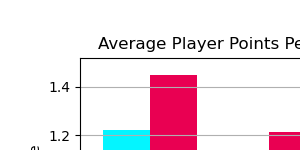

In [2]:

#2022/23 Season Data
gws_23_filepath = "merged_gw_23.csv" 
fixtures_23_filepath = "fixtures_23.csv" 

gws_23_df = pd.read_csv(gws_23_filepath)
fixtures_23_df = pd.read_csv(fixtures_23_filepath)

merged_df = gws_23_df.merge(fixtures_23_df, how='inner', left_on='fixture',right_on='id')

#Calculate Points
points_list = []
for i in tqdm(range(0,len(merged_df)),'Calculating Points'):
    
    pts = 0
    
    ###########################################
    #Played Time Points
    if (merged_df["minutes_x"][i] > 0) & (merged_df["minutes_x"][i] < 60):
        pts += 1
        
    elif (merged_df["minutes_x"][i] >= 60):
        pts += 2
        
    ###########################################
    if (merged_df["minutes_x"][i] > 0):
        #Goals Scored
        if (merged_df["position"][i] in (["GK","DEF"])):
            pts += merged_df["goals_scored"][i]*6

        elif (merged_df["position"][i] == "MID"):
            pts += merged_df["goals_scored"][i]*5

        elif (merged_df["position"][i] == "FWD"):
            pts += merged_df["goals_scored"][i]*4

        ###########################################
        #Assists
        pts += merged_df["assists"][i]*3

        ###########################################
        #Clean Sheet
        if (merged_df["position"][i] in (["GK","DEF"])) & (merged_df["goals_conceded"][i] == 0) \
            & (merged_df["minutes_x"][i] >= 60):
            pts += 4

        elif (merged_df["position"][i] == "MID") & (merged_df["goals_conceded"][i] == 0) \
            & (merged_df["minutes_x"][i] >= 60):
            pts += 1

        ###########################################
        #Saves
        if (merged_df["position"][i] == "GK"):
            pts += np.floor(merged_df["saves"][i]/3)

        ###########################################
        #Penalty Saves
        if (merged_df["position"][i] == "GK"):
            pts += merged_df["penalties_saved"][i]*5

        ###########################################
        #Penalty Misses
        if (merged_df["penalties_missed"][i] > 0):
            pts += merged_df["penalties_missed"][i]*(-2)

        ###########################################
        #Own Goals
        if (merged_df["own_goals"][i] > 0):
            pts += merged_df["own_goals"][i]*(-2)

        ###########################################
        #Yellow cards
        if (merged_df["yellow_cards"][i] > 0):
            pts += merged_df["yellow_cards"][i]*(-1)

        ###########################################
        #Red cards
        if (merged_df["red_cards"][i] > 0) & (merged_df["yellow_cards"][i] == 0):
            pts += merged_df["red_cards"][i]*(-3)

        ###########################################
        #Goals conceded
        if (merged_df["position"][i] in (["GK","DEF"])) & (merged_df["goals_conceded"][i] >= 2):
            pts += np.floor(merged_df["goals_conceded"][i]/2)*(-1)

        pts += merged_df["bonus"][i]
    
    points_list.append(pts)
        
merged_df['points'] = points_list


#Determine Avg Points For Home & Away vs Opponent Difficulty
home_query = f"""
        SELECT
            COUNT(DISTINCT id) AS matches,
            team_h_difficulty,
            AVG(points) AS avg_points
        FROM 
            merged_df
        WHERE was_home = True
        GROUP BY team_h_difficulty
        """

away_query = f"""
        SELECT
            COUNT(DISTINCT id) AS matches,
            team_a_difficulty,
            AVG(points) AS avg_points
        FROM 
            merged_df
        WHERE was_home = False
        GROUP BY team_a_difficulty
        """

home_diff_df = sql.sqldf(home_query)

away_diff_df = sql.sqldf(away_query)

#Plot Bar Graph Comparing Avg Player Points vs Opponenet Difficulty (Home & Away)
plt.figure()

x = np.arange(len(away_diff_df['avg_points']))

plt.bar(x - 0.2, away_diff_df['avg_points'],label='Away',width=0.4,color="#04f5ff")

plt.bar(x + 0.2, home_diff_df['avg_points'],label='Home',width=0.4,color="#e90052")

plt.xlabel('Opponent Difficulty')
plt.ylabel('Avg. Player Points Per Game')
plt.title('Average Player Points Per Game vs Opponent Difficulty')
plt.xticks(x,home_diff_df['team_h_difficulty'])
plt.grid(axis="y")
plt.legend()

From the figure above, there is a clear relationship between the opponentns difficulty vs the average points scored by a player. As the opponenet gets harder the average points scored per player decreases. This is true, for players playing both home and away. However, home advantage clealrly plays an important role as not matter the team difficulty, when a team is playing at home they are more likely to score higher points compared to when they are playing away.

Therefore, we are able to draw two key insights fromt his analysis.
1. A player is more likely to score higher points when playing at home.
2. The less difficult the opponent the more points a player is likely to score.

While these may seem obvious, it will help us determine which fixtures to target when selecting players. As we want to focus on teams playing at home against easy opponents.

### 2. Best game week formation

The FPL has a fixed set of formations, these are:
* 4-4-2
* 4-5-1
* 4-3-3
* 5-3-2
* 5-4-1
* 3-4-3
* 3-5-2

To review, we will look at the average points scored per position, as well as the distributions of points scored for each position to identify any trends of differences.

*Note when calculating the averages we will only count those for players who played at least 1 minute in a game.*

<IPython.core.display.Javascript object>


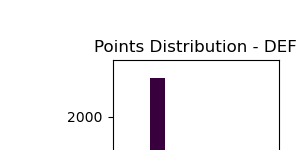

###############################################
DEF
Mean = 2.63
Median = 1.0
Mode = 1.0
STD = 2.86
###############################################
MID
Mean = 2.74
Median = 2.0
Mode = 1.0
STD = 2.79
###############################################
FWD
Mean= 3.0
Median = 2.0
Mode = 1.0
STD = 3.31


In [3]:
###############################################################################################################################
#Query points for positions exlcuding GK

pos_query = f"""
        SELECT
            position,
            points
        FROM 
            merged_df
        WHERE minutes_x > 0
        AND position <> 'GK'
        """

pos_df = sql.sqldf(pos_query)

###############################################################################################################################
# Distribution & Stats For Defenders
plt.figure(figsize=(9,5))
plt.subplot(1,3,1)

plt.hist(pos_df['points'].loc[pos_df['position'] == 'DEF'],color="#38003c")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.title("Points Distribution - DEF")
print("###############################################")
print("DEF")
print(f"Mean = {round(pos_df['points'].loc[pos_df['position'] == 'DEF'].mean(),2)}")
print(f"Median = {round(pos_df['points'].loc[pos_df['position'] == 'DEF'].median(),2)}")
print(f"Mode = {pos_df['points'].loc[pos_df['position'] == 'DEF'].mode().values[0]}")
print(f"STD = {round(pos_df['points'].loc[pos_df['position'] == 'DEF'].std(),2)}")

###############################################################################################################################
# Distribution & Stats For Midfielders

plt.subplot(1,3,2)
plt.hist(pos_df['points'].loc[pos_df['position'] == 'MID'],color="#38003c")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.title("Points Distribution - MID")
print("###############################################")
print("MID")
print(f"Mean = {round(pos_df['points'].loc[pos_df['position'] == 'MID'].mean(),2)}")
print(f"Median = {round(pos_df['points'].loc[pos_df['position'] == 'MID'].median(),2)}")
print(f"Mode = {pos_df['points'].loc[pos_df['position'] == 'MID'].mode().values[0]}")
print(f"STD = {round(pos_df['points'].loc[pos_df['position'] == 'MID'].std(),2)}")

###############################################################################################################################
# Distribution & Stats For Forwards

plt.subplot(1,3,3)
plt.hist(pos_df['points'].loc[pos_df['position'] == 'FWD'],color="#38003c")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.title("Points Distribution - FWD")
print("###############################################")
print("FWD")
print(f"Mean= {round(pos_df['points'].loc[pos_df['position'] == 'FWD'].mean(),2)}")
print(f"Median = {round(pos_df['points'].loc[pos_df['position'] == 'FWD'].median(),2)}")
print(f"Mode = {pos_df['points'].loc[pos_df['position'] == 'FWD'].mode().values[0]}")
print(f"STD = {round(pos_df['points'].loc[pos_df['position'] == 'FWD'].std(),2)}")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.6, hspace=0)  # Adjust the values as needed

Analyzing the distirbutions for each position, we can see that the distributions for both the MID and FWD are quite similar in shape, demonstrating a Poisson type distribution, with a long tail to the right. 

Interestingly, the DEF have a bimodal distribution with modes at 1 and 6 points. The reason for this is due to clean sheets. Clean sheets are not uncommon in football, and therefore, we see the existence of this second mode. Furthermore, because the clean sheet benefits all the defenders, all the defenders get this reward as opposed to a goal where only 1 player gets the credit.

Analyzing the average points per game. We see that FWD's have the highest average of 3 points per game, followed by MID with an average of 2.74 and DEF with and average of 2.63 points per game. This is unsurprisng as their main objective is to score goals, plus they have lower probabilities of points deductions from red cards and own goals as they have less responsibility to defend. 

We also see that MID have the lowest STD and therefore, the lowest variance. This is good for predictability of performance.

Based on the above findings, we can see that maximizing the number for forwards should allow for the highest points scoring potential. This gives us 2 possible formations; 4-3-3 and 3-4-3. Since MID have a higher average points per game, and a lower variance, we defientely want more MID than DEF to maximize our point scoring potential. 

Therefore, the best formation is **3-4-3**.

## 3. The Best XI

From our previous analysis, when creating a team that will maximize our points scoring potential this is what we know:

1. Home advantage > opponent difficulty
2. 3-4-3 formation

However, for determining the preferable order in which we want to select players based on home advantage vs opponent difficulty, we saw that there was an alternating pattern between home, away and match difficulty. Where,

    Rank 1: Home & Difficulty = 2
    Rank 2: Away & Difficulty = 2
    Rank 3: Home & Difficulty = 3
    Rank 4: Away & Difficulty = 3
    ...
    etc,.
With Rank 1 being the most preferred option.

Therefore, what we want to do is apply this ranking system to players for their upcoming system, and use this ranking system for optimizing the selection of players.

But what if a team have 2 matches in the same game week? This should technically double our points scoring potential for some players. Therefore, we would need to factor this into our ranking. To do this we will using the following logic:

* $Rank_{max}/(GW_{matches})^2$. 

By doing this, we are placing emphasis in the points scoring ability of the highest ranking game, and by dividng by the number of matches squared we are also increasing the priority the more games that are being played.

*Example: Team A has 2 games, 1 Home and 1 Away, each with a difficulty of 3. This means that the Home game would have a rank of 3, and the away game would also have a rank of 4. Therefore, the highest rank is 3. However, we want to priortize this fixture over Team B who have one game with the same rank. Therefore, we divide this by 2. This will therefore give us a rank of 1.5.*



In [4]:
## LIVE FANTASY

fpl_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
json_data = r.get(fpl_url).json()

fpl_data_df = pd.DataFrame(json_data['elements'])

fixtures_url = "https://fantasy.premierleague.com/api/fixtures/"
json_data = r.get(fixtures_url).json()

# print(json_data.keys())
fixtures_df = pd.DataFrame(json_data)

#Find Current/Next Gameweek Fixtures
gw_fixtures_df = pd.DataFrame()
horizon = 0
for i in sorted(fixtures_df['event'].unique()):
    
    check = fixtures_df.loc[fixtures_df['event'] == i]
    
    #Find the first gameweek where not all the games have started
    if check['started'].all() == False:
        gw = i
        gw_fixtures_df = pd.concat([gw_fixtures_df,check])
        horizon += 1
        
    #Append maximum of 3 match weeks
    if i <= 37:
        if horizon == 1:
            break
    
    else:
        continue
    
#Drop stats column as it is not needed
gw_fixtures_df = gw_fixtures_df.drop(columns='stats')

rank_query = f"""
            SELECT
                team,
                AVG(rank) AS avg_rank,
                COUNT(*) AS gw_matches,
                CASE WHEN COUNT(*) > 1 THEN
                    (CAST(AVG(rank) AS FLOAT)/(CAST(COUNT(*) AS FLOAT)*CAST(COUNT(*) AS FLOAT)))
                ELSE rank END AS new_rank
            FROM
                (SELECT
                    team_h AS team,
                    event AS gws,
                    team_h_difficulty AS opponent_difficulty,
                    (team_h_difficulty - 1) AS rank
                FROM
                    gw_fixtures_df
                UNION ALL
                    SELECT
                        team_a AS team,
                        event AS gws,
                        team_a_difficulty AS opponent_difficulty,
                        (team_a_difficulty) AS rank
                    FROM
                gw_fixtures_df) all_matches
            GROUP BY team
            """

#Ranking for upcoming match difficulty for each team
gw_fixtures_rank_df = sql.sqldf(rank_query)
print(gw_fixtures_rank_df)

    team  avg_rank  gw_matches  new_rank
0      1       2.0           1     2.000
1      2       2.0           1     2.000
2      3       4.0           1     4.000
3      4       4.0           2     1.000
4      5       2.0           1     2.000
5      6       3.0           1     3.000
6      7       5.0           1     5.000
7      8       2.0           1     2.000
8      9       1.0           1     1.000
9     10       2.0           1     2.000
10    11       2.0           2     0.500
11    12       3.5           2     0.875
12    13       2.0           2     0.500
13    14       2.0           1     2.000
14    15       1.0           1     1.000
15    16       1.0           1     1.000
16    17       2.0           1     2.000
17    18       1.0           1     1.000
18    19       2.0           1     2.000
19    20       3.0           1     3.000


Now that we have determined the ranking for each team, we will join this to the player data and filter the players accoprdingly. We will filter players based on:
* Player availability (injured, international break etc.)
* If the team has no games in that week, we want to filter them out for being eleible for selection.

In [5]:
#Format Player Name
fpl_data_df["name"] = fpl_data_df["first_name"].str[0] + "." + fpl_data_df["second_name"]

#Join Player Data To Upcoming Fixtures & Ranking
gw_merged_df = fpl_data_df.merge(gw_fixtures_rank_df,on="team",how="inner")

#Select Players Available To Play
gw_merged_df = gw_merged_df.loc[(gw_merged_df['chance_of_playing_this_round'] >= 75)
                             & (gw_merged_df['chance_of_playing_next_round'] >= 75)
                             & (gw_merged_df['new_rank'].isna() == False)].reset_index(drop=True)


Since we want to optimize our team for the 3-4-3 formation, it means that we will have 1 GK, 2 DEF and 1 MID on the bench. Because bench players do not get any points, we therefore, want to maximize our budget available for the starting line-up so we can select the best players while minimizing our budget constraints. Therefore, we will select the cheapest players available to fill these positions on the bench and deduct their cost from the budget when optimizing the team.

*Note that since we are preselecting our bench players, our bench will not be considered when optimizing the team, and thus, it is possible that predicted starting X1 plus the bench might not meet the constraints of maximum 3 players from each team. However, we can simply swap-out or choose the next best option when selecting the final team, and it won't impact our starting line-up.*

In [6]:
#Select Bench Based On Minimum Value
gk_bench_idx = gw_merged_df['now_cost'].loc[gw_merged_df['element_type'] == 1].idxmin()
def_bench_idx = ((gw_merged_df.loc[gw_merged_df['element_type'] == 2]).sort_values(by=['now_cost']).iloc[0:2]).index.to_list()
mid_bench_idx = gw_merged_df['now_cost'].loc[gw_merged_df['element_type'] == 3].idxmin()


bench_df = gw_merged_df.loc[[gk_bench_idx,mid_bench_idx]+def_bench_idx].reset_index(drop=True)

### Optimization Algorithm

**Objective Function:** $arg_{max}(1/Rank \times Score_{PCA})$

Since, the objective is to maximize the result we use $1/Rank$, since games with a high rank (e.g. 1) will contribute a bigger scaling compared to a low rank (e.g. 4). The $Score_{PCA}$ is the $k=1$ mean score of the normalized metrics such as *form, points_per_game, goals_scored, ict_index etc.* Using Principal Component Analysis (PCA) we could use dimensionality reduction to reduce all these metrics into a single score. All the metrics were standardized so that the metrics have the same scaling.

**Constraints:**
- Budget <= 1000
- Team Players <= 3 
- GK == 1
- DEF == 3
- MID == 4
- FWD == 3

<IPython.core.display.Javascript object>


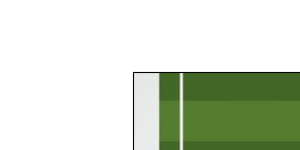

In [7]:
################################################################################################################################
#Create optimization function
def OptimizeTeam(fpl_data_df):
    gk_cons = 1
    def_cons = 3
    mid_cons = 4
    fwd_cons = 3
    players_from_team_cons = 3
    
    metrics = ['form','selected_by_percent','points_per_game','total_points','value_form', 
               'value_season', 'minutes', 'goals_scored',
               'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
               'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
               'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
               'ict_index', 'starts', 'expected_goals', 'expected_assists',
               'expected_goal_involvements', 'expected_goals_conceded',
               'expected_goals_per_90', 'saves_per_90', 'expected_assists_per_90',
               'expected_goal_involvements_per_90', 'expected_goals_conceded_per_90']
    
    # Standardization
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(fpl_data_df[metrics])
    df_standardized = pd.DataFrame(df_standardized, columns=[f"{c}_zscore" for c in metrics])
    
    #Invert the negative statistics (more = worse)
    df_standardized[['goals_conceded_zscore', 'own_goals_zscore',
                     'expected_goals_conceded_zscore','expected_goals_conceded_per_90_zscore',
                     'penalties_missed_zscore', 'yellow_cards_zscore', 'red_cards_zscore']
                   ] = df_standardized[['goals_conceded_zscore', 'own_goals_zscore',
                                        'expected_goals_conceded_zscore','expected_goals_conceded_per_90_zscore',
                                        'penalties_missed_zscore', 'yellow_cards_zscore', 'red_cards_zscore']].mul(-1)


    # Apply PCA
    pca = PCA(n_components=1)  # You can specify the number of components you want to keep
    principal_components = pca.fit_transform(df_standardized)

    # Create a DataFrame for the principal components
    components_df = pd.DataFrame(data=principal_components, columns=['PCA_Score'])
    
    
    fpl_data_df = pd.concat([fpl_data_df,components_df],axis=1)
    

    # Create a LP maximization problem
    prob = LpProblem("Player_Selection_Optimization", LpMaximize)
    
    # Decision variables
    selected_players = LpVariable.dicts("Player", fpl_data_df["name"], cat="Binary")
    
    # Objective function: maximize total performance
    
    #We use 1/rank so we can maximize the function 1/1 is higher than 1/5
    prob += lpSum(1/fpl_data_df.loc[fpl_data_df["name"] == player, "new_rank"].values[0] * 
                  fpl_data_df.loc[fpl_data_df["name"] == player, "PCA_Score"].values[0] * 
                  selected_players[player] for player in fpl_data_df["name"])

    # Constraints: exactly 2 GK, 5 DEF, 5 MID, 3 FWD, team affiliation, and budget
    prob += lpSum(selected_players[player] for player in fpl_data_df["name"] if fpl_data_df.loc[fpl_data_df["name"] == player, "element_type"].values[0] == 1) == gk_cons
    prob += lpSum(selected_players[player] for player in fpl_data_df["name"] if fpl_data_df.loc[fpl_data_df["name"] == player, "element_type"].values[0] == 2) == def_cons
    prob += lpSum(selected_players[player] for player in fpl_data_df["name"] if fpl_data_df.loc[fpl_data_df["name"] == player, "element_type"].values[0] == 3) == mid_cons
    prob += lpSum(selected_players[player] for player in fpl_data_df["name"] if fpl_data_df.loc[fpl_data_df["name"] == player, "element_type"].values[0] == 4) == fwd_cons
    
    budget_constraint = 1000 - bench_df["now_cost"].sum()  #Budget constraint
    prob += lpSum(fpl_data_df.loc[fpl_data_df["name"] == player, "now_cost"].values[0] * selected_players[player] for player in fpl_data_df["name"]) <= budget_constraint

    #Up to 3 players max from each team constraint
    for team in fpl_data_df["team"]:
        prob += lpSum(selected_players[player] for player in fpl_data_df["name"] if fpl_data_df.loc[fpl_data_df["name"] == player, 'team'].values[0] == team) <= players_from_team_cons
        
    # Solve the problem
    prob.solve()


    #Create data frame for starting line-up
    starting_xi_df = pd.DataFrame()
    for player in fpl_data_df["name"]:
        if selected_players[player].varValue == 1:
            starting_xi_df = pd.concat([starting_xi_df,fpl_data_df.loc[fpl_data_df["name"] == player]])
            
    return starting_xi_df.sort_values(by='element_type',ignore_index=True)

#Starting XI Dataframe
starting_xi_df = OptimizeTeam(gw_merged_df)

##############################################################################################################################
#Show Predicted Team

# Define player positions (x, y)
player_positions = {
    starting_xi_df["name"][0]: (0, 7),
    starting_xi_df["name"][1]: (3, 5.5),
    starting_xi_df["name"][2]: (-3, 5.5),
    starting_xi_df["name"][3]: (0, 5.5),
    starting_xi_df["name"][4]: (1.5, 4),
    starting_xi_df["name"][5]: (-1.5, 4),
    starting_xi_df["name"][6]: (-4.5, 4),
    starting_xi_df["name"][7]: (4.5, 4),
    starting_xi_df["name"][8]: (3, 2.5),
    starting_xi_df["name"][9]: (-3, 2.5),
    starting_xi_df["name"][10]: (0, 2.5),
    bench_df["name"][0]: (4.5, 9),
    bench_df["name"][1]: (1.5, 9),
    bench_df["name"][2]: (-1.5, 9),
    bench_df["name"][3]: (-4.5, 9)
}

# Load the football pitch image
img = mpimg.imread('football_pitch_template.jpg')

# Plot player positions
plt.figure(figsize=(8, 6))
plt.imshow(img, extent=[-6, 6, 0, 8])  # Display image covering entire plot area

for position, (x, y) in player_positions.items():
    plt.scatter(x, y, label=position, color='#e90052', s=500, marker='o')

# Add labels for player positions
for position, (x, y) in player_positions.items():
    plt.text(x, y-0.5, position, fontsize=8, ha='center', va='center',weight='bold')

# Set field limits and labels
plt.xlim(-6, 6)
plt.ylim(0, 10)
plt.title("Saudi Splurge FC",weight='bold')
# Hide x and y ticks
plt.xticks([])
plt.yticks([])

# Show plot
plt.gca().invert_yaxis()  # Invert y-axis to match football field orientation
plt.show()


## Conclusions

Recall the deliverables for our project.

1. Evaluate how match difficulty impacts points scoring potential.
    * Our analysis indicated the easier the match difficulty, the more points a player will score on average. This is boosted, when a team has home advantage.
    
2. Determine the best starting formation to use for each game week.
    * On average, FWD's average the highest points per game, followed by MID and then DEF. Therefore, the ideal formation is to maximize the presence of FWD's and MID's, resulting in a 3-4-3 formation.
    
3. Provide a predicted team that factors in the rules and constraints of the FPL such as bugdet, maximum numbers of players per team etc.
    * An optimzation function was created that would optimize the team according to the upcoming match difficulties, while factoring in the players performance metrics, while considering the constraints enforced by the FPL rules. 


## Future Work

Therefore, going forward, we will continiue to monitor the teams performance to test whether using data has helped imrpoved our overall ranking. Therefore, overall ranking will be the metric that we use to evaluate our success criteria.

Possible improvements to the algorithm:
- The current selection process chooses the best team each week. However, because these teams could be significantly different week in and week out. There will be alot of points deductions due to transfer fees. Therefore, accounting for this could imrpove the algorithm. One way in which this has been factored into the code is to increase the horizon for games which we want to determine our match difficulty for. By increasing this horizon we can determine a more stable team that can remain unchanged for a set of fixtures.